# Lesson 1: Deep Learning for Coders

This notebook will go over *some* of the practical material discussed in [lesson 1](https://course.fast.ai/videos/?lesson=1) of the fastai 2020 course.

## Example 1: Computer Vision

In [1]:
from fastai.vision.all import *
from pathlib import Path

download one of the standard datasets provided by fasta, the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) which is a 37 category pet dataset with roughly 200 images for each class. 

In [2]:
path = untar_data(URLs.PETS)/'images'
path

Path('/storage/data/oxford-iiit-pet/images')

### Create an ImageDataLoader

- Fastai needs to know where to get the image labels from. Normally these labels are part of the filenames or folder structure. In this case the filenames contain the animal breeds.
- `american_bulldog_146.jpg` and `Siamese_56.jpg` for example
    - it so happens that cat breeds start with an uppercase letter.
- For this example, we will not classify all 37 breeds. We will instead classify whether the images are of dogs or cats.

First define a function `is_cat` that checks whether the first letter in the image label is uppercase. `is_cat` returns a boolean value that will be used as the new image label. 
- `from_name_func` applies the function to our data to create the labels we need.
- `valid_pct=0.2`: hold 20% of the data aside for the validation set, 80% will be used for the training set
- `item_tfms=Resize(224)`: resize images to 224x224
    - fastai provides item transforms (applied to each image in this case) and batch transform which are applied to a batch of items at a time.

In [12]:
# check a few image names to confirm that 
# dog images start with lowercase filenames
# cat images start with uppercase filenames

files = get_image_files(path)
files[0],files[6]

(Path('/storage/data/oxford-iiit-pet/images/american_bulldog_146.jpg'),
 Path('/storage/data/oxford-iiit-pet/images/Siamese_56.jpg'))

In [3]:
def is_cat(x): return x[0].isupper()

dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

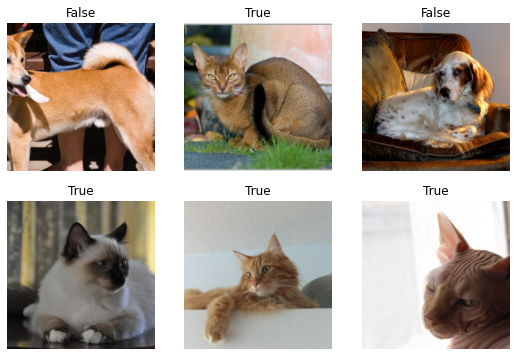

In [4]:
# take a look at some of the data
dls.show_batch(max_n=6)

In [30]:
# check number of items in training and test datasets
len(dls.train_ds), len(dls.valid_ds)

(5912, 1478)

### Create a `cnn_learner`
- using the `resnet34` architecture
    - [resnet paper](https://arxiv.org/abs/1512.03385)
- this is a pretrained learner, which means when we fit the model, we will not need to train from scratch, rather, we will only fine tune the model
- by default, `freeze_epochs` is set to 1

In [68]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [7]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.149828,0.034039,0.008796,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.078255,0.016130,0.006089,01:01


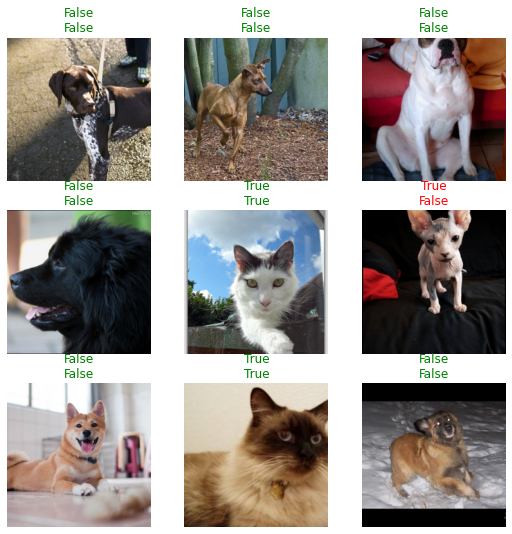

In [8]:
learn.show_results()

## Testing the model

- Lets load in a picture of a cat and a dog to check the model

In [41]:
img_01 = Path.cwd()/'img_1.PNG'
img_02 = Path.cwd()/'img_2.PNG'

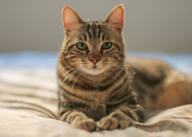

In [54]:
im1 = PILImage.create(img_01)
im2 = PILImage.create(img_02)

im1.to_thumb(192)

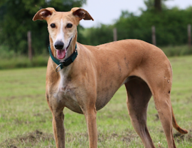

In [55]:
im2.to_thumb(192)

In [70]:
images = [im1, im2]

for i in images:
    is_cat,_,probs = learn.predict(i)
    
    print(f"Is this a cat?: {is_cat}.")
    print(f"Probability it's a cat: {probs[1].item():.5f}")
    

Is this a cat?: False.
Probability it's a cat: 0.01819


Is this a cat?: True.
Probability it's a cat: 0.88616


## Example 2: Tabular

For this example we will use the [Adults](https://archive.ics.uci.edu/ml/datasets/Adult) data set. Our goal is to predict if a person is earning above or below $50k per year using information such as age, working class, education and occupation. There are about 32K rows in the dataset.

In [1]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)
path

Path('/storage/data/adult_sample')

In [2]:
df = pd.read_csv(path/'adult.csv')

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [3]:
len(df)

32561

### Create an TabularDataLoader

Again we create data loader using the `path`. We need to specify some information such as the y variable (the value we want to predict), and we also need to specify which columns contain categorical values and which contain continuous variables. Do this using `cat_names` and `cont_names`.

Some data processing needs to occur..
- we need to specify how to handle missing data. Info below from the [docs](https://docs.fast.ai/tabular.core)
    - `FillMissing` by default sets `fill_strategy=median`
    - `Normalize` will normalize the continuous variables (substract the mean and divide by the std)
    - `Categorify` transform the categorical variables to something similar to `pd.Categorical`
    
This is another classification problem. Our goal is to predict whether a persons salary was below 50k (0) or above (1).

In [4]:
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

I'm going to keep some of the data at the end of the set aside for testing. `df[:32500]` will select from row 0 to 32500, the remaining rows will not be seen by the model

In [5]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df[:32500]))

to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary',
                   splits=splits)

In [6]:
dls = to.dataloaders(bs=64)

In [7]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,HS-grad,Married-spouse-absent,Other-service,Unmarried,White,False,32.000000,128016.002920,9.0,<50k
1,Private,7th-8th,Married-civ-spouse,Exec-managerial,Wife,White,False,52.000000,194259.000001,4.0,<50k
2,Private,Some-college,Widowed,Exec-managerial,Unmarried,White,False,31.000000,73796.004491,10.0,<50k
3,Private,Some-college,Separated,Other-service,Not-in-family,White,False,64.000001,114993.998143,10.0,<50k
4,Self-emp-not-inc,Assoc-voc,Married-civ-spouse,Prof-specialty,Husband,White,False,68.000000,116902.996854,11.0,<50k
5,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,False,42.000000,190178.999991,13.0,>=50k
6,Self-emp-not-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,False,66.000000,291362.001320,15.0,<50k
7,Self-emp-not-inc,Bachelors,Married-civ-spouse,Sales,Husband,White,False,63.000001,298249.000475,13.0,>=50k
8,Private,Masters,Divorced,Tech-support,Not-in-family,White,False,47.000000,606752.001736,14.0,<50k
9,State-gov,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,42.000000,345969.005416,13.0,>=50k


We can see that our y values have been turned into the categories 0 and 1.

In [8]:
dls.y.value_counts()

0    19756
1     6244
Name: salary, dtype: int64

In [9]:
learn = tabular_learner(dls, metrics=accuracy)

In [10]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.366288,0.354235,0.834769,00:06
1,0.367247,0.348617,0.839538,00:05
2,0.358275,0.345206,0.839077,00:06


In [11]:
learn.show_results()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,5.0,11.0,3.0,11.0,1.0,5.0,1.0,1.494630,1.838917,2.322299,0.0,1.0
1,5.0,12.0,3.0,8.0,1.0,5.0,1.0,-0.558852,-0.690051,-0.421488,0.0,0.0
2,3.0,10.0,3.0,11.0,6.0,3.0,1.0,0.174535,0.000144,1.146390,1.0,1.0
3,5.0,10.0,3.0,5.0,1.0,5.0,1.0,0.467889,-1.014015,1.146390,1.0,1.0
4,5.0,16.0,5.0,9.0,4.0,5.0,1.0,-1.365576,4.387854,-0.029518,0.0,0.0
5,5.0,10.0,1.0,5.0,2.0,5.0,1.0,0.174535,0.616141,1.146390,0.0,0.0
6,5.0,10.0,3.0,2.0,6.0,5.0,1.0,1.494630,0.898075,1.146390,0.0,1.0
7,5.0,12.0,3.0,5.0,6.0,5.0,1.0,0.101196,-0.713219,-0.421488,1.0,1.0
8,7.0,2.0,3.0,4.0,1.0,5.0,1.0,-0.338836,0.932638,-1.205427,0.0,0.0


### Check the model by making predictions on the dataset

using the data that was held aside which the model has not yet seen.

In [22]:
# pick some random rows of the df
sample_df = df.iloc[[32513,32542,32553]]

sample_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
32513,23,Private,209955,HS-grad,9.0,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<50k
32542,34,Private,98283,Prof-school,15.0,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,1564,40,India,>=50k
32553,35,Self-emp-inc,135436,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,>=50k


Lets loop through these rows and make predictions, printing out the predicted class, the probabilities and the actual class.

In [34]:
for i, r in sample_df.iterrows():
    row, clas, probs = learn.predict(r)
    print(f'the predicted class is {clas}')
    print(f'with a probability of {probs}')
    print(f'the actual class was {r.salary}')

the predicted class is 0
with a probability of tensor([0.9911, 0.0089])
the actual class was <50k


the predicted class is 0
with a probability of tensor([0.6258, 0.3742])
the actual class was >=50k


the predicted class is 1
with a probability of tensor([0.0919, 0.9081])
the actual class was >=50k
